In [2]:
from prototree.prototree import ProtoTree
from util.log import Log

from util.args import get_args, save_args, get_optimizer
from util.data import get_dataloaders
from util.init import init_tree
from util.net import get_network, freeze
from util.visualize import gen_vis
from util.analyse import *
from util.save import *
from prototree.train import train_epoch, train_epoch_kontschieder
from prototree.test import eval, eval_fidelity
from prototree.prune import prune
from prototree.project import project, project_with_class_constraints
from prototree.upsample import upsample

import torch
from shutil import copy
from copy import deepcopy
import torchvision.transforms as transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



In [3]:
def get_nih(
    augment: bool, train_dir: str, project_dir: str, test_dir: str, img_size=224
):
    shape = (3, img_size, img_size)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    normalize = transforms.Normalize(mean=mean, std=std)
    transform_no_augment = transforms.Compose(
        [transforms.Resize(size=(img_size, img_size)), transforms.ToTensor(), normalize]
    )
    if augment:
        transform = transforms.Compose(
            [
                transforms.Resize(
                    size=(img_size + 32, img_size + 32)
                ),  # resize to 256x256
                transforms.RandomOrder(
                    [
                        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                        transforms.ColorJitter(brightness=0.25, contrast=0.25),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomAffine(
                            15, translate=(0.1, 0.1), scale=(0.9, 1.1)
                        ),
                    ]
                ),
                transforms.RandomCrop(size=(img_size, img_size)),  # crop to 224x224
                transforms.ToTensor(),
                normalize,
            ]
        )
    else:
        transform = transform_no_augment
    trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
    projectset = torchvision.datasets.ImageFolder(
        project_dir, transform=transform_no_augment
    )
    testset = torchvision.datasets.ImageFolder(test_dir, transform=transform_no_augment)
    classes = trainset.classes
    return trainset, projectset, testset, classes, shape


In [4]:
def get_dataloaders(batch_size = 32):
    """
    Get data loaders
    """
    # Obtain the dataset
    trainset, projectset, testset, classes, shape = get_nih(True,
            "./data/NIH_CHEST_XRAYS/dataset/train_corners",
            "./data/NIH_CHEST_XRAYS/dataset/train_crop",
            "./data/NIH_CHEST_XRAYS/dataset/test_full", img_size=224)
    c, w, h = shape
    # Determine if GPU should be used
    
    # Uncomment for CUDA
    cuda = torch.cuda.is_available()

    # Uncomment for MPS
    # cuda = not args.disable_cuda and torch.backends.mps.is_available()
    
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, pin_memory=cuda
    )
    projectloader = torch.utils.data.DataLoader(
        projectset,
        #    batch_size=args.batch_size,
        batch_size=int(
            batch_size / 4
        ),  # make batch size smaller to prevent out of memory errors during projection
        shuffle=False,
        pin_memory=cuda,
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, pin_memory=cuda
    )
    print("Num classes (k) = ", len(classes), flush=True)
    return trainloader, projectloader, testloader, classes, c

In [5]:
if torch.cuda.is_available():
        # device = torch.device('cuda')
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = torch.device('cpu')


trainloader, projectloader, testloader, classes, num_channels = get_dataloaders(
        batch_size=32
    )

Num classes (k) =  3


In [5]:
# EPOCHS = 150

# # Assuming `trainloader` is already defined and contains the training data
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Define ResNet-50 model
# resnet50 = torchvision.models.resnet50(pretrained=False)
# resnet50.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# # Training loop
# resnet50.train()  # Set model to training mode
# for epoch in range(EPOCHS):  # Loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = resnet50(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:  # Print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')


In [6]:
img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

normalize = transforms.Normalize(mean=mean, std=std)

transform_no_augment = transforms.Compose(
        [transforms.Resize(size=(img_size, img_size)), transforms.ToTensor(), normalize]
    )

In [7]:
resnet50 = torch.load(r'runs/run_prototree/checkpoints/best_test_model/resnet50.pth', map_location=device)


# Assuming `testloader` is properly defined and contains the test data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet50.eval()  # Set model to evaluation mode
predictions = []
current = []

# Iterate over the test loader
for i, (xs, ys) in enumerate(testloader):
    xs, ys = xs.to(device), ys.to(device)

    # Forward pass
    with torch.no_grad():
        out = resnet50(xs)
    ys_pred = torch.argmax(out, dim=1)

    # Accumulate predictions and true labels
    predictions.append(ys_pred.cpu())  # Move predictions to CPU for easier handling
    current.append(ys.cpu())  # Move true labels to CPU for easier handling

# Concatenate all predictions and true labels
predictions = torch.cat(predictions, dim=0)
current = torch.cat(current, dim=0)

# Convert predictions and true labels to lists if needed
predictions = predictions.tolist()
current = current.tolist()


# Baseline
***

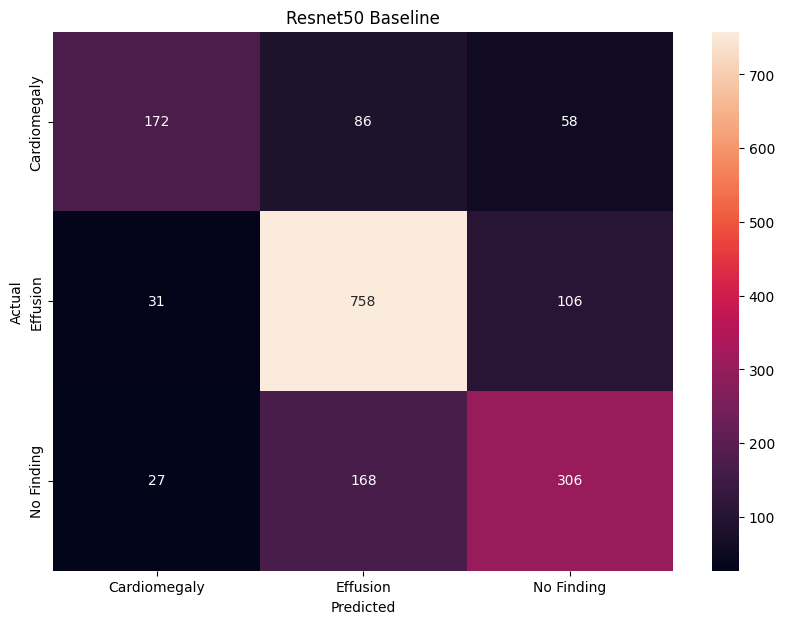

              precision    recall  f1-score   support

Cardiomegaly       0.75      0.54      0.63       316
    Effusion       0.75      0.85      0.79       895
  No Finding       0.65      0.61      0.63       501

    accuracy                           0.72      1712
   macro avg       0.72      0.67      0.69      1712
weighted avg       0.72      0.72      0.72      1712



In [9]:
classes = testloader.dataset.classes

cm = confusion_matrix(current, predictions)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Resnet50 Baseline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Calculate precision, recall, and F1-score for each class
report = classification_report(current, predictions, target_names=classes)
print(report)


# ProtoTree
***

In [10]:
tree = torch.load('runs/run_prototree/checkpoints/best_test_model/model.pth', map_location=device)

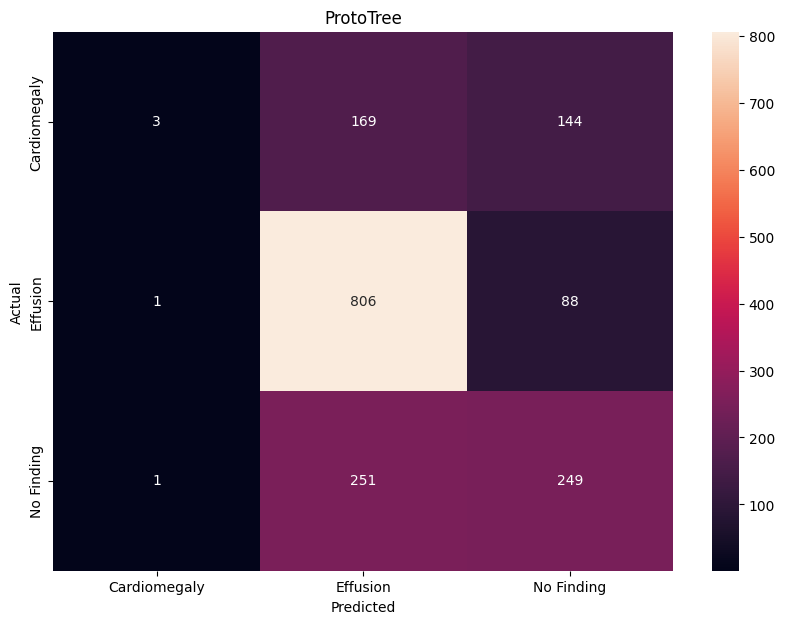

              precision    recall  f1-score   support

Cardiomegaly       0.60      0.01      0.02       316
    Effusion       0.66      0.90      0.76       895
  No Finding       0.52      0.50      0.51       501

    accuracy                           0.62      1712
   macro avg       0.59      0.47      0.43      1712
weighted avg       0.61      0.62      0.55      1712



In [11]:
current = []
predictions = []
tree.eval()
for i, (xs, ys) in enumerate(testloader):
    xs, ys = xs.to(device), ys.to(device)

    out, test_info = tree.forward(xs, 'distributed')
    ys_pred = torch.argmax(out, dim=1)
    predictions.append(ys_pred.cpu())
    current.append(ys.cpu())

# Concatenate all predictions and true labels
predictions = torch.cat(predictions, dim=0)
current = torch.cat(current, dim=0)

# Convert predictions and true labels to lists if needed
predictions = predictions.tolist()
current = current.tolist()

classes = testloader.dataset.classes

cm = confusion_matrix(current, predictions)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('ProtoTree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(current, predictions, target_names=classes)
print(report)

# Validation Curves

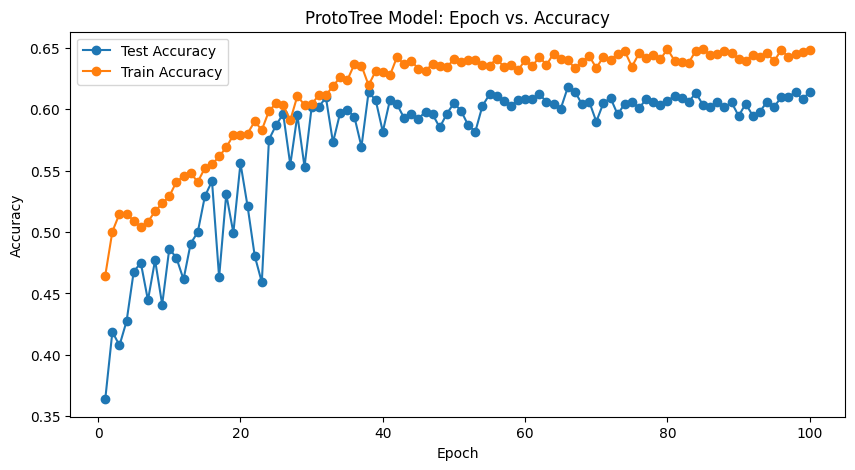

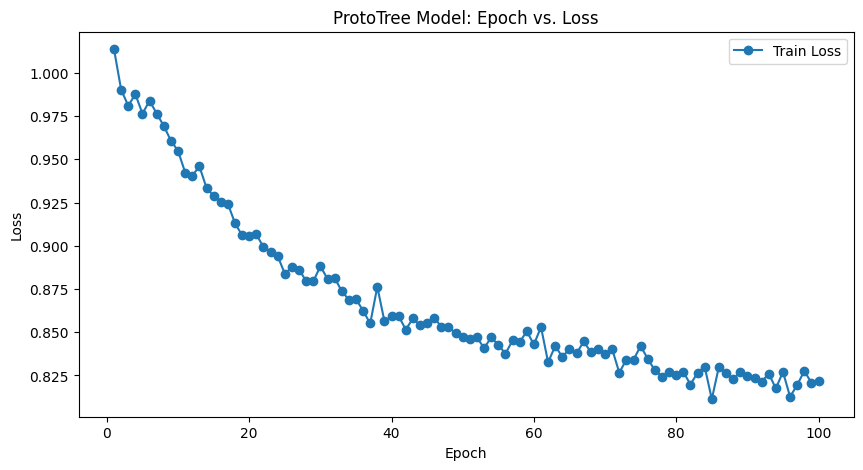

In [14]:
# Extract necessary data
epochs = df['epoch']
test_acc = df['test_acc']
train_acc = df['mean_train_acc']
train_loss = df['mean_train_crossentropy_loss_during_epoch']

# Plot epoch vs. accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o', linestyle='-')
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ProtoTree Model: Epoch vs. Accuracy')
plt.legend()
plt.grid(False)
plt.show()

# Plot epoch vs. loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ProtoTree Model: Epoch vs. Loss')
plt.legend()
plt.grid(False)
plt.show()